<a href="https://colab.research.google.com/github/peregrine109/public/blob/main/signate3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データセットのダウンロード

In [ ]:
!  pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=829f3a18de32995279231ced689b7ff9c45d87529cc7ce8b967f7c5dafc9ef64
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


[アカウント設定](https://signate.jp/account_settings#)からAPI Tokenをダウンロードし、アップロードしてください

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving signate.json to signate.json


In [ ]:
! mkdir -p /root/.signate && mv signate.json /root/.signate/

In [ ]:
! signate download --competition-id=1

submit_sample.csv

test.csv

train.csv


Download completed.


# データの観察

In [ ]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submit = pd.read_csv('submit_sample.csv', header=None)

In [ ]:
display(df_train.head())

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


欠損値を確認します

In [ ]:
df_train.isnull().sum()
df_test.isnull().sum()

,0
id,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0


データの型を確認します

In [ ]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27128 non-null  int64 
 1   age        27128 non-null  int64 
 2   job        27128 non-null  object
 3   marital    27128 non-null  object
 4   education  27128 non-null  object
 5   default    27128 non-null  object
 6   balance    27128 non-null  int64 
 7   housing    27128 non-null  object
 8   loan       27128 non-null  object
 9   contact    27128 non-null  object
 10  day        27128 non-null  int64 
 11  month      27128 non-null  object
 12  duration   27128 non-null  int64 
 13  campaign   27128 non-null  int64 
 14  pdays      27128 non-null  int64 
 15  previous   27128 non-null  int64 
 16  poutcome   27128 non-null  object
 17  y          27128 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18083 entri

ヒストグラム

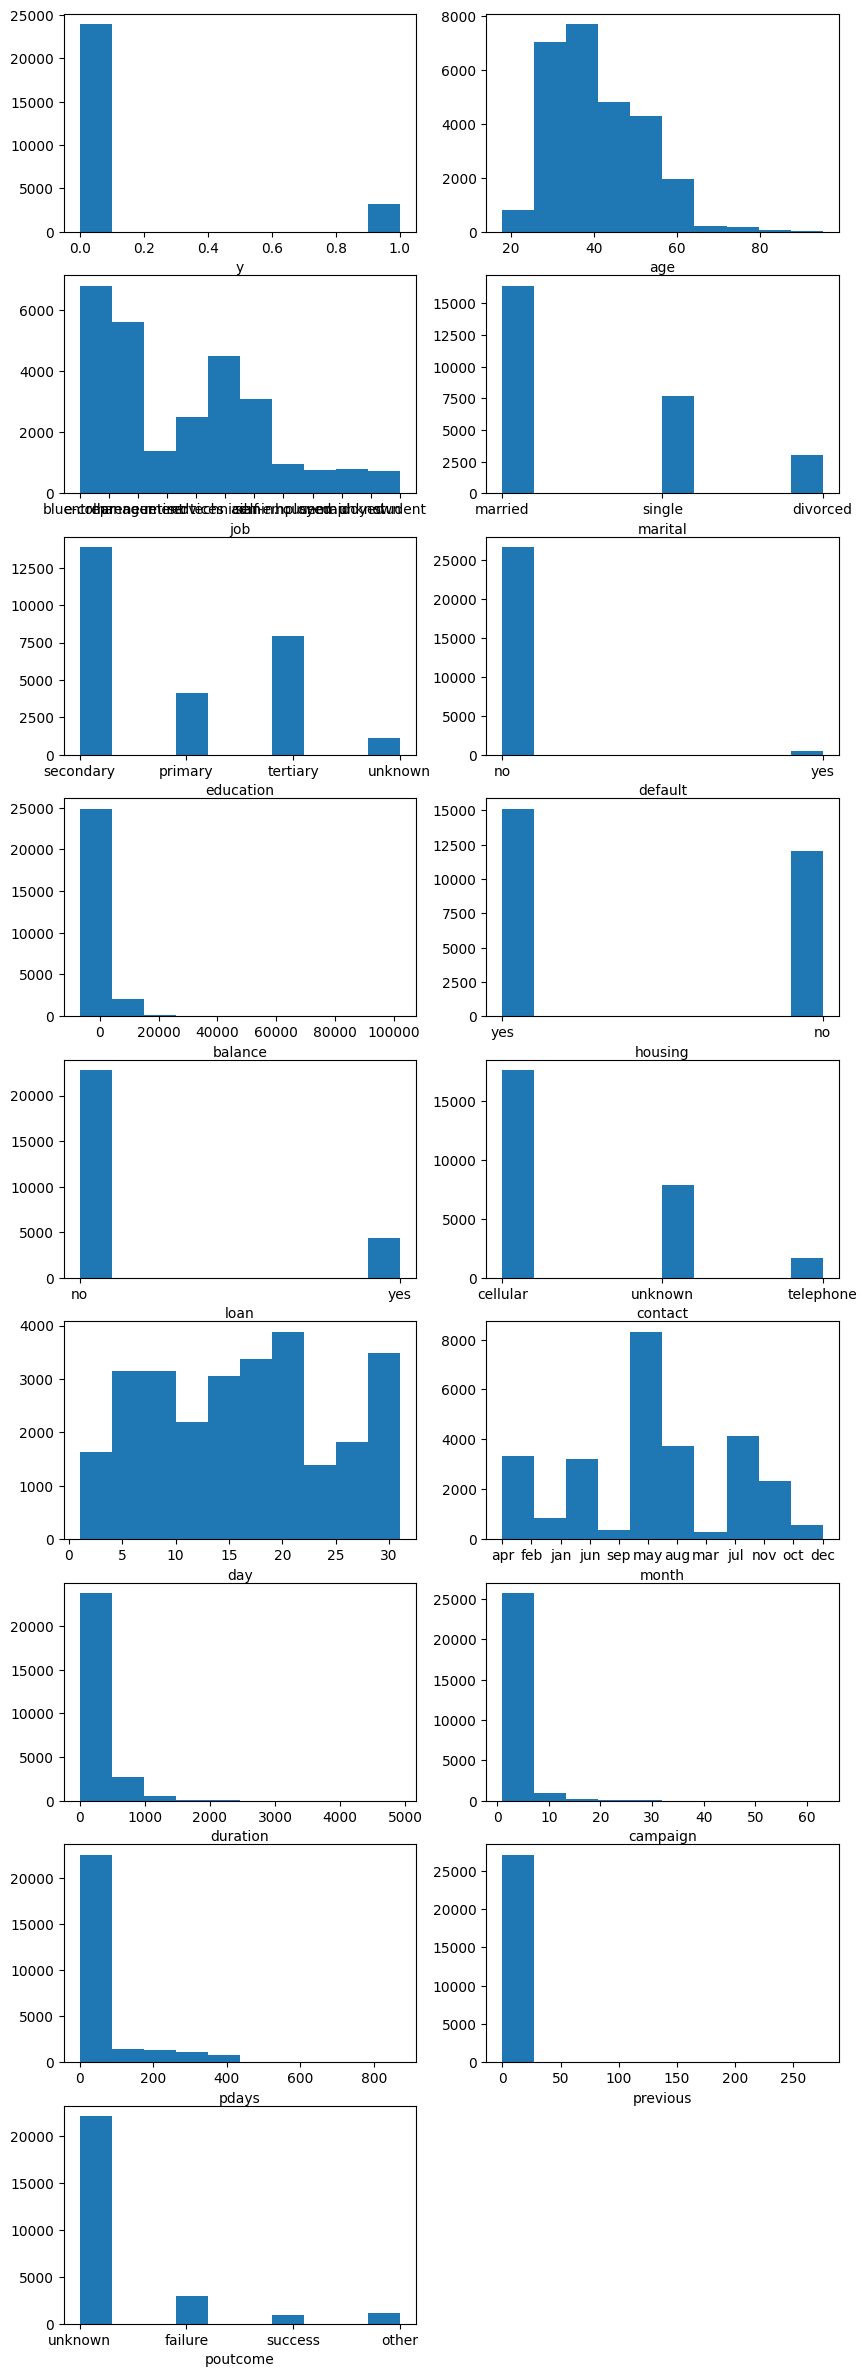

In [ ]:
plt.figure(figsize=(10,30))
for i,col in enumerate(["y","age","job","marital","education","default","balance","housing","loan","contact","day","month","duration","campaign","pdays","previous","poutcome"]):
    plt.subplot(9,2,i+1)
    plt.hist(df_train[col])
    plt.xlabel(col)
plt.show()

monthは数字に直した方が良い。unknownを欠損値とも考えられる

jobの中身を確認する

In [ ]:
df_train["job"].value_counts()

,count
job,
blue-collar,5886
management,5620
technician,4491
admin.,3085
services,2506
retired,1391
self-employed,945
entrepreneur,914
unemployed,790


# データの前処理・学習1

In [ ]:
month = {"jan": "1",
         "feb": "2",
         "mar": "3",
         "apr": "4",
         "may": "5",
         "jun": "6",
         "jul": "7",
         "aug": "8",
         "sep": "9",
         "oct": "10",
         "nov": "11",
         "dec": "12"}

def preprocess1(df_train, df_test):
    """前処理を行う関数"""
    df = pd.concat([df_train, df_test]) #df_trainとdf_testを結合
    #monthを数字を割り当てる
    for k, v in month.items():
        df["month"] = df["month"].replace(k,v)
    df["month"] = df["month"].astype("float") #データをfloat型に変換
    #yesに1、noに0を割り当てる
    yesno_columns = ["default","housing","loan"]
    for col in yesno_columns:
        df[col] = df[col].replace("yes","1").replace("no","0").astype("float") #データをfloat型に変換
    # それぞれcategoryに変換
    categorical_columns = ["job","marital","education","contact","poutcome"]
    for col in categorical_columns:
        df[col] = df[col].astype("category")
    # int型をfloat型に変換
    int_columns = ["age","balance","day","duration","campaign","pdays","previous"]
    for col in int_columns:
        df[col] = df[col].astype("float")
    return df[~df["y"].isnull()], df[df["y"].isnull()] #df_trainとdf_testに分離

train, test = preprocess1(df_train, df_test)

In [ ]:
display(train.head())

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39.0,blue-collar,married,secondary,0.0,1756.0,1.0,0.0,cellular,3.0,4.0,939.0,1.0,-1.0,0.0,unknown,1.0
1,2,51.0,entrepreneur,married,primary,0.0,1443.0,0.0,0.0,cellular,18.0,2.0,172.0,10.0,-1.0,0.0,unknown,1.0
2,3,36.0,management,single,tertiary,0.0,436.0,0.0,0.0,cellular,13.0,4.0,567.0,1.0,595.0,2.0,failure,1.0
3,4,63.0,retired,married,secondary,0.0,474.0,0.0,0.0,cellular,25.0,1.0,423.0,1.0,-1.0,0.0,unknown,1.0
4,5,31.0,management,single,tertiary,0.0,354.0,0.0,0.0,cellular,30.0,4.0,502.0,1.0,9.0,2.0,success,1.0


In [ ]:
target = 'y'

feature_columns = ["age",
                   "job",
                   "marital",
                   "education",
                   "default",
                   "balance",
                   "housing",
                   "loan",
                   "contact",
                   "day",
                   "month",
                   "duration",
                   "campaign",
                   "pdays",
                   "previous",
                   "poutcome"]

x = train[feature_columns].copy()
y = train[target].copy()

モデルの学習

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

auc_list = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(x)):
    x_train, x_valid = x.iloc[train_idx], x.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = lgb.LGBMRegressor(
        objective='binary',
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42
    )

    model.fit(
        x_train,
        y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
        early_stopping(50),
        log_evaluation(0)
        ],
    )

    y_pred = model.predict(x_valid)
    auc = roc_auc_score(y_valid, y_pred)
    auc_list.append(auc)
    print(f'Fold {fold + 1} AUC: {auc:.4f}')

print(f'\nAverage CV AUC: {np.mean(auc_list):.4f}')


[LightGBM] [Info] Number of positive: 2565, number of negative: 19137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 985
[LightGBM] [Info] Number of data points in the train set: 21702, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118192 -> initscore=-2.009665
[LightGBM] [Info] Start training from score -2.009665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[160]	valid_0's auc: 0.938189	valid_0's binary_logloss: 0.188473
Fold 1 AUC: 0.9382
[LightGBM] [Info] Number of positive: 2564, number of negative: 19138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

ハイパーパラメータの最適化

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 30, 130),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42,
        'verbosity': -1
    }

    auc_list = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, valid_idx in kf.split(x):
        x_train, x_valid = x.iloc[train_idx], x.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = lgb.LGBMRegressor(**params)

        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric='auc',
            callbacks=[early_stopping(50), log_evaluation(0)],
            categorical_feature=x.select_dtypes('category').columns.tolist()
        )

        y_pred = model.predict(x_valid)
        auc = roc_auc_score(y_valid, y_pred)
        auc_list.append(auc)

    return np.mean(auc)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-05-17 02:54:44,682] A new study created in memory with name: no-name-33de071a-b9e4-4efb-be1f-cfdc223e6f72


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's auc: 0.937204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid_0's auc: 0.936518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	valid_0's auc: 0.932646
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[589]	valid_0's auc: 0.923784
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[388]	valid_0's auc: 0.93368


[I 2025-05-17 02:54:59,329] Trial 0 finished with value: 0.933679827457643 and parameters: {'learning_rate': 0.022126098681635762, 'num_leaves': 46, 'min_child_samples': 43, 'subsample': 0.7118431905518565, 'colsample_bytree': 0.7880920691257254, 'reg_alpha': 1.522029702465896, 'reg_lambda': 1.1968971608817929}. Best is trial 0 with value: 0.933679827457643.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's auc: 0.936867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[119]	valid_0's auc: 0.936702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	valid_0's auc: 0.931998
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[214]	valid_0's auc: 0.923865
Training until validation scores don't improve for 50 rounds


[I 2025-05-17 02:55:05,863] Trial 1 finished with value: 0.9345690930382573 and parameters: {'learning_rate': 0.06271055075357437, 'num_leaves': 30, 'min_child_samples': 27, 'subsample': 0.6800491164604464, 'colsample_bytree': 0.7296094403383507, 'reg_alpha': 0.2503218882780319, 'reg_lambda': 4.421588858709825}. Best is trial 1 with value: 0.9345690930382573.


Early stopping, best iteration is:
[173]	valid_0's auc: 0.934569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[168]	valid_0's auc: 0.936737
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.935444
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.931184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's auc: 0.922713
Training until validation scores don't improve for 50 rounds


[W 2025-05-17 02:55:10,697] Trial 2 failed with parameters: {'learning_rate': 0.10270238232075314, 'num_leaves': 53, 'min_child_samples': 33, 'subsample': 0.9533721544262771, 'colsample_bytree': 0.6708690986452851, 'reg_alpha': 9.234283738965502, 'reg_lambda': 0.16201687244100688} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-55-12073d011bd2>", line 25, in objective
    model.fit(
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py", line 1189, in fit
    super().fit(
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py", line 307, in train
    booster.update(fobj=fobj)
  File "/usr/local/

KeyboardInterrupt: 

In [ ]:
print("Best trial:")
print(f"  AUC: {study.best_value:.4f}")
print("  Best params:")
for key, val in study.best_params.items():
    print(f"    {key}: {val}")

Best trial:
  AUC: 0.9351
  Best params:
    learning_rate: 0.04178852782587751
    num_leaves: 66
    min_child_samples: 36
    subsample: 0.7934919030579008
    colsample_bytree: 0.6306436531750749
    reg_alpha: 0.005832201483616873
    reg_lambda: 0.010136822261424004


テストデータを学習

In [ ]:
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators': 1000,
    'random_state': 42
})

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = []
predict = np.zeros(len(test))  # テストデータ用の平均予測

for fold, (train_idx, valid_idx) in enumerate(kf.split(x)):
    x_train, x_valid = x.iloc[train_idx], x.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = lgb.LGBMRegressor(**best_params)

    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)],
        categorical_feature=x.select_dtypes('category').columns.tolist()
    )

    models.append(model)

    # このfoldのモデルでtestを予測
    predict += model.predict(test[feature_columns]) / kf.n_splits

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's auc: 0.937227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's auc: 0.937038
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.932616
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[193]	valid_0's auc: 0.92417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.935102


特徴量の重要度を可視化する

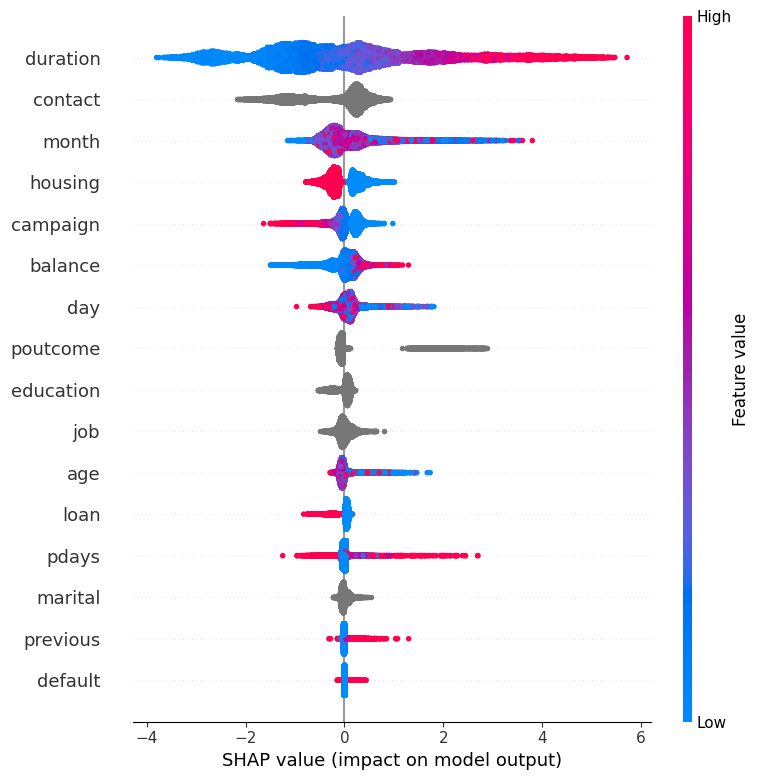

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(x)

shap.summary_plot(shap_values, x)

予測データを提出する

In [ ]:
# sample_submitの読み込み
submit = pd.read_csv('submit_sample.csv', header=None)

# 予測結果の適用
submit[1] = predict
submit.to_csv('submission.csv', header=None, index=False)

In [ ]:
! signate submit --competition-id=1 /content/submission.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.


# データの前処理・学習2

In [ ]:
train, test = preprocess1(df_train, df_test)

相関行列

<Axes: >

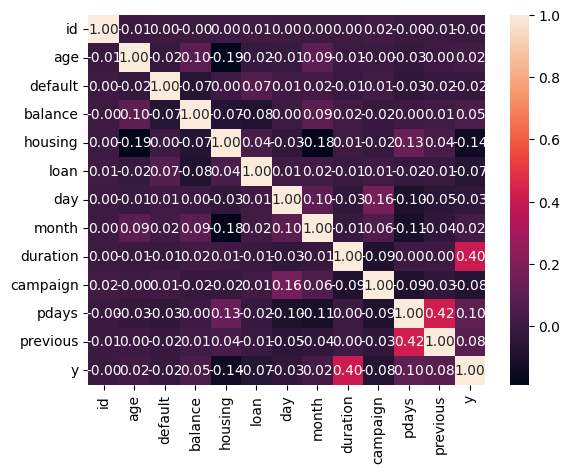

In [ ]:
numeric_train = train.select_dtypes(include=np.number)
sns.heatmap(numeric_train.corr(), annot = True, fmt=".2f")

相関が高いpdaysとpreviousの散布図

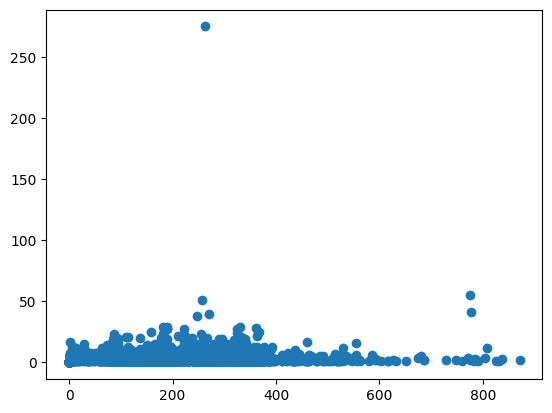

In [ ]:
plt.scatter(train["pdays"],train["previous"])
plt.show()

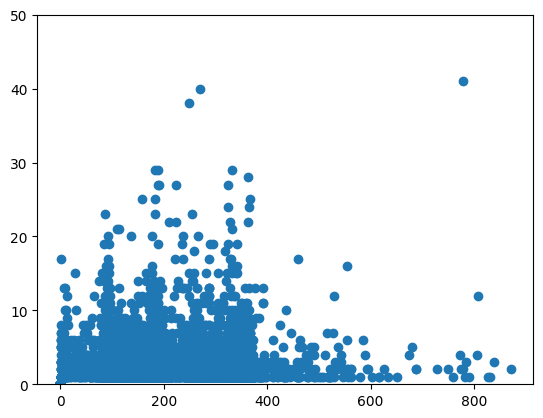

In [ ]:
plt.scatter(train["pdays"],train["previous"])
plt.ylim(0, 50)
plt.show()

相関が高いdurationとyの散布図

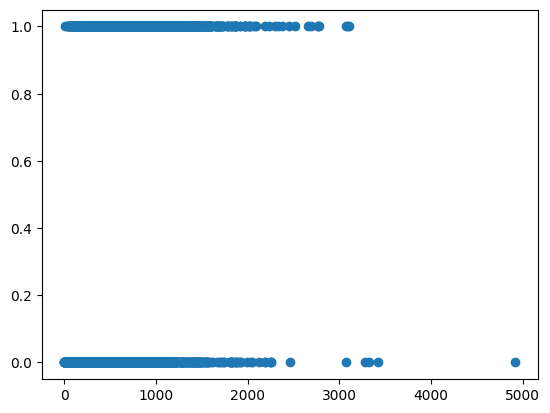

In [ ]:
plt.scatter(train["duration"],train["y"])
plt.show()

y=0,1のときのdurationのヒストグラム

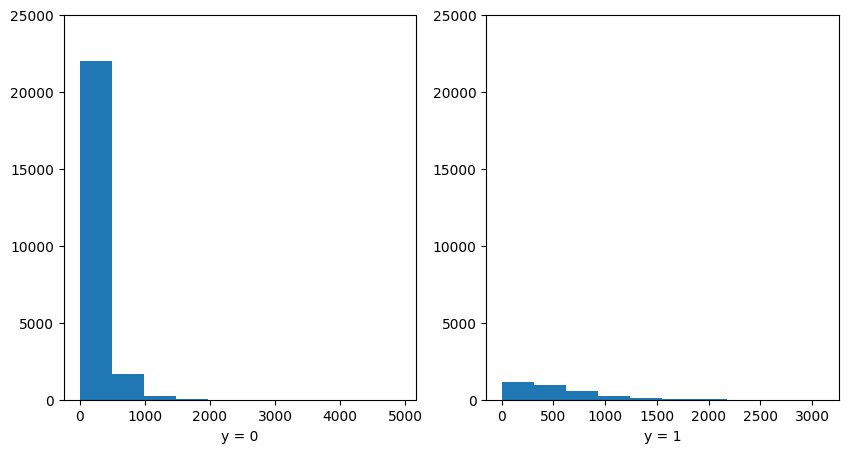

In [ ]:
plt.figure(figsize=(10,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.hist(train[train["y"] == i]["duration"])
    plt.ylim(0, 25000)
    plt.xlabel(f"y = {str(i)}")
plt.show()

In [ ]:
month = {"jan": "1",
         "feb": "2",
         "mar": "3",
         "apr": "4",
         "may": "5",
         "jun": "6",
         "jul": "7",
         "aug": "8",
         "sep": "9",
         "oct": "10",
         "nov": "11",
         "dec": "12"}

def preprocess2(df_train, df_test):
    """前処理を行う関数"""
    df = pd.concat([df_train, df_test]) #df_trainとdf_testを結合
    #monthを数字を割り当てる
    for k, v in month.items():
        df["month"] = df["month"].replace(k,v)
    df["month"] = df["month"].astype("float") #データをfloat型に変換
    #yesに1、noに0を割り当てる
    yesno_columns = ["default","housing","loan"]
    for col in yesno_columns:
        df[col] = df[col].replace("yes","1").replace("no","0").astype("float") #データをfloat型に変換
    # それぞれcategoryに変換
    categorical_columns = ["job","marital","education","contact","poutcome"]
    for col in categorical_columns:
        df[col] = df[col].astype("category")
    #for col in categorical_columns:
        #df = pd.get_dummies(df, columns=[col], drop_first=True)
    #df = pd.get_dummies(df)
    # 欠損値の個数を特徴量に追加
    df["missing"] = (df == "unknown").sum(axis=1).astype("float")
    # int型をfloat型に変換
    int_columns = ["age","balance","day","campaign","pdays","duration","previous"]
    for col in int_columns:
        df[col] = df[col].astype("float")
    return df[~df["y"].isnull()], df[df["y"].isnull()] #df_trainとdf_testに分離

train, test = preprocess2(df_train, df_test)

In [ ]:
train

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,missing
0,1,39.0,blue-collar,married,secondary,0.0,1756.0,1.0,0.0,cellular,3.0,4.0,939.0,1.0,-1.0,0.0,unknown,1.0,1.0
1,2,51.0,entrepreneur,married,primary,0.0,1443.0,0.0,0.0,cellular,18.0,2.0,172.0,10.0,-1.0,0.0,unknown,1.0,1.0
2,3,36.0,management,single,tertiary,0.0,436.0,0.0,0.0,cellular,13.0,4.0,567.0,1.0,595.0,2.0,failure,1.0,0.0
3,4,63.0,retired,married,secondary,0.0,474.0,0.0,0.0,cellular,25.0,1.0,423.0,1.0,-1.0,0.0,unknown,1.0,1.0
4,5,31.0,management,single,tertiary,0.0,354.0,0.0,0.0,cellular,30.0,4.0,502.0,1.0,9.0,2.0,success,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,27124,42.0,blue-collar,married,primary,0.0,1455.0,1.0,0.0,cellular,2.0,2.0,279.0,2.0,269.0,2.0,other,0.0,0.0
27124,27125,34.0,services,single,secondary,0.0,719.0,1.0,0.0,unknown,15.0,5.0,362.0,3.0,-1.0,0.0,unknown,0.0,2.0
27125,27126,36.0,blue-collar,single,primary,0.0,49.0,1.0,0.0,unknown,8.0,5.0,405.0,1.0,-1.0,0.0,unknown,0.0,2.0
27126,27127,33.0,housemaid,married,primary,0.0,209.0,0.0,0.0,cellular,12.0,8.0,76.0,4.0,-1.0,0.0,unknown,0.0,1.0


In [ ]:
def Holdout_target_encoding(df,column,target):
    kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
    box = np.zeros(len(df))
    box[:] = np.nan
    for idx1, idx2 in kf.split(df):
        train = df.iloc[idx1]
        val = df[column].iloc[idx2]
        mean = train.groupby(column, observed=False)[target].mean()
        for i,m in mean.items():
            for v in val.index:
                if val[v] == i:
                    box[v] = m
    df[column + "_target"] = box
    return df

def target_encoding_test(test,train,column,target):
    mean = train.groupby(column, observed=False)[target].mean()
    test[column + "_target"] = test[column].map(mean).astype("float")
    return test

target_encoding_columns = ["job","marital","education","contact","poutcome"]

for col in target_encoding_columns:
    train = Holdout_target_encoding(train, col, "y")
    test = target_encoding_test(test, train, col, "y")

In [ ]:
display(train.head())

,id,age,job,marital,education,default,balance,housing,loan,contact,...,pdays,previous,poutcome,y,missing,job_target,marital_target,education_target,contact_target,poutcome_target
0,1,39.0,blue-collar,married,secondary,0.0,1756.0,1.0,0.0,cellular,...,-1.0,0.0,unknown,1.0,1.0,0.070468,0.102685,0.108906,0.151562,0.092977
1,2,51.0,entrepreneur,married,primary,0.0,1443.0,0.0,0.0,cellular,...,-1.0,0.0,unknown,1.0,1.0,0.083562,0.100404,0.079035,0.144400,0.090228
2,3,36.0,management,single,tertiary,0.0,436.0,0.0,0.0,cellular,...,595.0,2.0,failure,1.0,0.0,0.134429,0.146143,0.143805,0.144400,0.125159
3,4,63.0,retired,married,secondary,0.0,474.0,0.0,0.0,cellular,...,-1.0,0.0,unknown,1.0,1.0,0.233363,0.102685,0.108906,0.151562,0.092977
4,5,31.0,management,single,tertiary,0.0,354.0,0.0,0.0,cellular,...,9.0,2.0,success,1.0,0.0,0.134429,0.146143,0.143805,0.144400,0.638360


In [ ]:
target = 'y'

feature_columns = ["age",
                   #"job",
                   #"marital",
                   #"education",
                   "default",
                   "balance",
                   "housing",
                   "loan",
                   #"contact",
                   "day",
                   "month",
                   "duration",
                   "campaign",
                   "pdays",
                   "previous",
                   #"poutcome",
                   "missing",
                   "job_target",
                   "marital_target",
                   "education_target",
                   "contact_target",
                   "poutcome_target"]

x = train[feature_columns].copy()
y = train[target].copy()

ニューラルネットワークを構成

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128) # バッチ正則化
        self.dropout1 = nn.Dropout(0.3) # ドロップアウト
        self.layer_2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) # バッチ正則化
        self.dropout2 = nn.Dropout(0.3) # ドロップアウト
        self.layer_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid() # BCEWithLogitsLoss is used, so remove sigmoid

    def forward(self, x):
        x = self.layer_1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.layer_2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.layer_out(x)
        # x = self.sigmoid(x) # BCEWithLogitsLoss is used, so remove sigmoid
        return x

In [ ]:
y.value_counts()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

auc_list = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(x)):
    x_train, x_valid = x.iloc[train_idx], x.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # データセットとデータローダーを作成
    x_train_tensor = torch.tensor(x_train.values.astype(np.float32))
    y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # モデルのインスタンス化
    input_dim = len(feature_columns)
    model = Net(input_dim)

    # 損失関数と最適化
    pos_weight = torch.tensor([23954 / 3174], dtype=torch.float32) # total negatives / total positives
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # 学習ループ
    epochs = 50
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

    # テストデータでの予測
    model.eval()
    valid_tensor = torch.tensor(x_valid[feature_columns].values.astype(np.float32))
    valid_dataset = TensorDataset(valid_tensor)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    y_pred = []
    with torch.no_grad():
        for inputs in valid_loader:
            outputs = (model(inputs[0]))
            y_pred.extend(outputs.sigmoid().squeeze().tolist())

    auc = roc_auc_score(y_valid, y_pred)
    auc_list.append(auc)
    print(f'Fold {fold + 1} AUC: {auc:.4f}')

print(f'\nAverage CV AUC: {np.mean(auc_list):.4f}')

Epoch 1/50, Loss: 0.9794
Epoch 2/50, Loss: 0.9293
Epoch 3/50, Loss: 0.9232
Epoch 4/50, Loss: 0.9145
Epoch 5/50, Loss: 0.8987
Epoch 6/50, Loss: 0.8973
Epoch 7/50, Loss: 0.8965
Epoch 8/50, Loss: 0.8755
Epoch 9/50, Loss: 0.8866
Epoch 10/50, Loss: 0.8693
Epoch 11/50, Loss: 0.8672
Epoch 12/50, Loss: 0.8615
Epoch 13/50, Loss: 0.8554
Epoch 14/50, Loss: 0.8644
Epoch 15/50, Loss: 0.8460
Epoch 16/50, Loss: 0.8577
Epoch 17/50, Loss: 0.8493
Epoch 18/50, Loss: 0.8480
Epoch 19/50, Loss: 0.8513
Epoch 20/50, Loss: 0.8612
Epoch 21/50, Loss: 0.8443
Epoch 22/50, Loss: 0.8449
Epoch 23/50, Loss: 0.8407
Epoch 24/50, Loss: 0.8419
Epoch 25/50, Loss: 0.8393
Epoch 26/50, Loss: 0.8366
Epoch 27/50, Loss: 0.8285
Epoch 28/50, Loss: 0.8318
Epoch 29/50, Loss: 0.8277
Epoch 30/50, Loss: 0.8249
Epoch 31/50, Loss: 0.8344
Epoch 32/50, Loss: 0.8263
Epoch 33/50, Loss: 0.8166
Epoch 34/50, Loss: 0.8286
Epoch 35/50, Loss: 0.8190
Epoch 36/50, Loss: 0.8241
Epoch 37/50, Loss: 0.8193
Epoch 38/50, Loss: 0.8259
Epoch 39/50, Loss: 0.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

auc_list = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(x)):
    x_train, x_valid = x.iloc[train_idx], x.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = lgb.LGBMRegressor(
        objective='binary',
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42
    )

    model.fit(
        x_train,
        y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
        early_stopping(50),
        log_evaluation(0)
        ],
    )

    y_pred = model.predict(x_valid)
    auc = roc_auc_score(y_valid, y_pred)
    auc_list.append(auc)
    print(f'Fold {fold + 1} AUC: {auc:.4f}')

print(f'\nAverage CV AUC: {np.mean(auc_list):.4f}')

[LightGBM] [Info] Number of positive: 2565, number of negative: 19137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 21702, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118192 -> initscore=-2.009665
[LightGBM] [Info] Start training from score -2.009665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	valid_0's auc: 0.937915	valid_0's binary_logloss: 0.189124
Fold 1 AUC: 0.9379
[LightGBM] [Info] Number of positive: 2564, number of negative: 19138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 30, 130),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42,
        'verbosity': -1
    }

    auc_list = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, valid_idx in kf.split(x):
        x_train, x_valid = x.iloc[train_idx], x.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = lgb.LGBMRegressor(**params)

        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric='auc',
            callbacks=[early_stopping(50), log_evaluation(0)]
        )

        y_pred = model.predict(x_valid)
        auc = roc_auc_score(y_valid, y_pred)
        auc_list.append(auc)

    return np.mean(auc)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-05-16 17:02:24,107] A new study created in memory with name: no-name-b10d6d08-a802-4430-aed0-3d5e48d06198


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.935266
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.933607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.929612
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.920196
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:02:27,511] Trial 0 finished with value: 0.9314842043126674 and parameters: {'learning_rate': 0.1315120815789366, 'num_leaves': 56, 'min_child_samples': 14, 'subsample': 0.6427783641044612, 'colsample_bytree': 0.9653802271389507, 'reg_alpha': 0.018574003716879728, 'reg_lambda': 0.020460181215301583}. Best is trial 0 with value: 0.9314842043126674.


Early stopping, best iteration is:
[97]	valid_0's auc: 0.931484
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.933761
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.934212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.929873
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.923692
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:02:31,381] Trial 1 finished with value: 0.9307328019602686 and parameters: {'learning_rate': 0.1422330433339641, 'num_leaves': 92, 'min_child_samples': 29, 'subsample': 0.8410267821558561, 'colsample_bytree': 0.6201724458313931, 'reg_alpha': 0.263743421228651, 'reg_lambda': 0.004897669622334083}. Best is trial 0 with value: 0.9314842043126674.


Early stopping, best iteration is:
[47]	valid_0's auc: 0.930733
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.931806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.932556
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.926419
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.918788
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:02:35,356] Trial 2 finished with value: 0.9296098375124252 and parameters: {'learning_rate': 0.17877704332329034, 'num_leaves': 92, 'min_child_samples': 27, 'subsample': 0.6519641925857724, 'colsample_bytree': 0.9193282761293367, 'reg_alpha': 0.025826803287555423, 'reg_lambda': 0.0039092904229936064}. Best is trial 0 with value: 0.9314842043126674.


Early stopping, best iteration is:
[47]	valid_0's auc: 0.92961
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.935703
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.934348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.930694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.922436
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:02:38,970] Trial 3 finished with value: 0.9320694066532222 and parameters: {'learning_rate': 0.17338483330797633, 'num_leaves': 37, 'min_child_samples': 29, 'subsample': 0.6027348583465678, 'colsample_bytree': 0.9943636785157876, 'reg_alpha': 2.4180461539305655, 'reg_lambda': 1.660713362409649}. Best is trial 3 with value: 0.9320694066532222.


Early stopping, best iteration is:
[38]	valid_0's auc: 0.932069
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.936777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.934681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.929806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.918239
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:02:41,860] Trial 4 finished with value: 0.9320977434368506 and parameters: {'learning_rate': 0.12512434016421797, 'num_leaves': 76, 'min_child_samples': 9, 'subsample': 0.7006148413685247, 'colsample_bytree': 0.8702129452252289, 'reg_alpha': 0.0014674256071367192, 'reg_lambda': 0.006738340340762294}. Best is trial 4 with value: 0.9320977434368506.


Early stopping, best iteration is:
[59]	valid_0's auc: 0.932098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.937013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.935096
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.931322
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.923741
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:02:46,513] Trial 5 finished with value: 0.9330118435019935 and parameters: {'learning_rate': 0.0965379022463665, 'num_leaves': 67, 'min_child_samples': 22, 'subsample': 0.9233702365322158, 'colsample_bytree': 0.8216833047526209, 'reg_alpha': 0.031162994537340987, 'reg_lambda': 2.514887406397167}. Best is trial 5 with value: 0.9330118435019935.


Early stopping, best iteration is:
[94]	valid_0's auc: 0.933012
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.935641
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.933808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.928933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.923974
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:02:51,932] Trial 6 finished with value: 0.9321168468864879 and parameters: {'learning_rate': 0.12621573776062836, 'num_leaves': 94, 'min_child_samples': 8, 'subsample': 0.7075031469001506, 'colsample_bytree': 0.7300375313788886, 'reg_alpha': 0.7087309793502639, 'reg_lambda': 0.05582946762407525}. Best is trial 5 with value: 0.9330118435019935.


Early stopping, best iteration is:
[48]	valid_0's auc: 0.932117
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.934559
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's auc: 0.933156
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.930471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's auc: 0.92265
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:02:57,153] Trial 7 finished with value: 0.9313578031542342 and parameters: {'learning_rate': 0.11541252857426654, 'num_leaves': 115, 'min_child_samples': 10, 'subsample': 0.888405455531741, 'colsample_bytree': 0.9396797059016349, 'reg_alpha': 4.310677713327246, 'reg_lambda': 7.263257502496287}. Best is trial 5 with value: 0.9330118435019935.


Early stopping, best iteration is:
[59]	valid_0's auc: 0.931358
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.936721
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's auc: 0.936301
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.931621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.923028
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:03:01,439] Trial 8 finished with value: 0.9338364757446684 and parameters: {'learning_rate': 0.09268392267552455, 'num_leaves': 62, 'min_child_samples': 28, 'subsample': 0.9075046684278204, 'colsample_bytree': 0.7077534408859439, 'reg_alpha': 0.09044087728539803, 'reg_lambda': 1.6678524736684672}. Best is trial 8 with value: 0.9338364757446684.


Early stopping, best iteration is:
[95]	valid_0's auc: 0.933836
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[437]	valid_0's auc: 0.936743
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[503]	valid_0's auc: 0.934492
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[458]	valid_0's auc: 0.931972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[557]	valid_0's auc: 0.923167
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[526]	valid_0's auc: 0.932496


[I 2025-05-16 17:03:20,760] Trial 9 finished with value: 0.9324963687526149 and parameters: {'learning_rate': 0.023828996975494773, 'num_leaves': 46, 'min_child_samples': 6, 'subsample': 0.6909178918295765, 'colsample_bytree': 0.9675874961095141, 'reg_alpha': 8.299437631951191, 'reg_lambda': 0.010776272092968893}. Best is trial 8 with value: 0.9338364757446684.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.935562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's auc: 0.933822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.930748
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.922892
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:03:26,124] Trial 10 finished with value: 0.9316911583504043 and parameters: {'learning_rate': 0.06327861033763597, 'num_leaves': 130, 'min_child_samples': 45, 'subsample': 0.9986806573086753, 'colsample_bytree': 0.7056658521522265, 'reg_alpha': 0.002150271443384846, 'reg_lambda': 0.3355880132072739}. Best is trial 8 with value: 0.9338364757446684.


Early stopping, best iteration is:
[110]	valid_0's auc: 0.931691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's auc: 0.938571
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.935483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.932324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.923297
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:03:31,519] Trial 11 finished with value: 0.9324947767984783 and parameters: {'learning_rate': 0.07887184757980774, 'num_leaves': 65, 'min_child_samples': 21, 'subsample': 0.9414100511034654, 'colsample_bytree': 0.7873720051628492, 'reg_alpha': 0.038436976769287125, 'reg_lambda': 0.6249830293722386}. Best is trial 8 with value: 0.9338364757446684.


Early stopping, best iteration is:
[160]	valid_0's auc: 0.932495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.936778
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.936184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.932052
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.923452
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:03:37,102] Trial 12 finished with value: 0.9345831022346579 and parameters: {'learning_rate': 0.07818474414117653, 'num_leaves': 69, 'min_child_samples': 37, 'subsample': 0.8043009930305122, 'colsample_bytree': 0.8223669840454585, 'reg_alpha': 0.12468718665265228, 'reg_lambda': 7.390020505164357}. Best is trial 12 with value: 0.9345831022346579.


Early stopping, best iteration is:
[114]	valid_0's auc: 0.934583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.937246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[209]	valid_0's auc: 0.935431
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	valid_0's auc: 0.932106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[405]	valid_0's auc: 0.924734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[329]	valid_0's auc: 0.934359


[I 2025-05-16 17:03:46,601] Trial 13 finished with value: 0.9343592734830747 and parameters: {'learning_rate': 0.04506415116357343, 'num_leaves': 31, 'min_child_samples': 41, 'subsample': 0.7802815195043828, 'colsample_bytree': 0.6755321697480805, 'reg_alpha': 0.20642999871182172, 'reg_lambda': 9.727312201579132}. Best is trial 12 with value: 0.9345831022346579.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.93777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's auc: 0.935904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's auc: 0.932953
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[377]	valid_0's auc: 0.924481
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[366]	valid_0's auc: 0.935481


[I 2025-05-16 17:03:56,086] Trial 14 finished with value: 0.9354812827584362 and parameters: {'learning_rate': 0.043823938282275945, 'num_leaves': 32, 'min_child_samples': 42, 'subsample': 0.7830870172072155, 'colsample_bytree': 0.6275860776975007, 'reg_alpha': 0.40062814312754885, 'reg_lambda': 6.6423948923307226}. Best is trial 14 with value: 0.9354812827584362.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[681]	valid_0's auc: 0.937818
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[382]	valid_0's auc: 0.935899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[426]	valid_0's auc: 0.932761
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[478]	valid_0's auc: 0.92338
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:04:10,880] Trial 15 finished with value: 0.9271216131971725 and parameters: {'learning_rate': 0.01380996971602282, 'num_leaves': 47, 'min_child_samples': 38, 'subsample': 0.7871102920850347, 'colsample_bytree': 0.7938700438050595, 'reg_alpha': 0.8850808736074048, 'reg_lambda': 0.001250077429581341}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[46]	valid_0's auc: 0.927122
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's auc: 0.937212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	valid_0's auc: 0.933454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.930864
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's auc: 0.922521
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:04:17,014] Trial 16 finished with value: 0.9330475032746497 and parameters: {'learning_rate': 0.05789585692696349, 'num_leaves': 107, 'min_child_samples': 49, 'subsample': 0.8279042189503164, 'colsample_bytree': 0.6083317366794266, 'reg_alpha': 0.00835881935905481, 'reg_lambda': 0.22437605603024838}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[123]	valid_0's auc: 0.933048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's auc: 0.936803
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's auc: 0.935345
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's auc: 0.932482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[314]	valid_0's auc: 0.922428
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's auc: 0.934


[I 2025-05-16 17:04:28,009] Trial 17 finished with value: 0.9340004470207216 and parameters: {'learning_rate': 0.03666193346793045, 'num_leaves': 76, 'min_child_samples': 39, 'subsample': 0.7514642633906018, 'colsample_bytree': 0.8774794257225047, 'reg_alpha': 0.8369429572460015, 'reg_lambda': 3.643653177430808}. Best is trial 14 with value: 0.9354812827584362.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.937391
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.935425
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.931752
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's auc: 0.922367
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:04:33,321] Trial 18 finished with value: 0.9337743895333472 and parameters: {'learning_rate': 0.07487722396565945, 'num_leaves': 47, 'min_child_samples': 35, 'subsample': 0.8652097330998936, 'colsample_bytree': 0.770453139266983, 'reg_alpha': 0.18504538010774232, 'reg_lambda': 0.6881800614038286}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[140]	valid_0's auc: 0.933774
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.936838
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.935788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's auc: 0.93076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's auc: 0.9219
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's auc: 0.932817


[I 2025-05-16 17:04:40,780] Trial 19 finished with value: 0.9328169883156934 and parameters: {'learning_rate': 0.03950811298637645, 'num_leaves': 84, 'min_child_samples': 34, 'subsample': 0.7458030117339265, 'colsample_bytree': 0.8410337440660838, 'reg_alpha': 0.0957912228137663, 'reg_lambda': 0.0917433041062471}. Best is trial 14 with value: 0.9354812827584362.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's auc: 0.937394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.935589
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.931475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.923534
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:04:44,508] Trial 20 finished with value: 0.9329242860244893 and parameters: {'learning_rate': 0.15392609543350122, 'num_leaves': 37, 'min_child_samples': 49, 'subsample': 0.8098515566306801, 'colsample_bytree': 0.6537231703009929, 'reg_alpha': 0.004973142298052224, 'reg_lambda': 4.46805735297744}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[76]	valid_0's auc: 0.932924
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[210]	valid_0's auc: 0.937592
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's auc: 0.93575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.93238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[218]	valid_0's auc: 0.923626
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:04:52,952] Trial 21 finished with value: 0.9343866550942214 and parameters: {'learning_rate': 0.0483366051090923, 'num_leaves': 33, 'min_child_samples': 43, 'subsample': 0.7714231049366286, 'colsample_bytree': 0.650586079075795, 'reg_alpha': 0.32345667559291597, 'reg_lambda': 9.64982723999032}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[234]	valid_0's auc: 0.934387
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's auc: 0.937798
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.935691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	valid_0's auc: 0.933303
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's auc: 0.923435
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:04:59,881] Trial 22 finished with value: 0.9351227746869104 and parameters: {'learning_rate': 0.05822410762636996, 'num_leaves': 31, 'min_child_samples': 44, 'subsample': 0.7548303297160927, 'colsample_bytree': 0.7531333052410094, 'reg_alpha': 0.47162630647531933, 'reg_lambda': 1.1301803992554438}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[293]	valid_0's auc: 0.935123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.937532
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.934542
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.932066
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's auc: 0.924043
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:05:05,289] Trial 23 finished with value: 0.9332321699544764 and parameters: {'learning_rate': 0.07725995901989666, 'num_leaves': 54, 'min_child_samples': 35, 'subsample': 0.7497022051090826, 'colsample_bytree': 0.756466658860015, 'reg_alpha': 1.67169198833428, 'reg_lambda': 1.084081644500938}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[142]	valid_0's auc: 0.933232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.937055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.93482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.932357
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.921081
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:05:08,229] Trial 24 finished with value: 0.9324177262182748 and parameters: {'learning_rate': 0.19897393461679028, 'num_leaves': 40, 'min_child_samples': 45, 'subsample': 0.8541118595770469, 'colsample_bytree': 0.746882106905339, 'reg_alpha': 0.5576626639285633, 'reg_lambda': 4.1860558120203395}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[55]	valid_0's auc: 0.932418
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	valid_0's auc: 0.937577
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	valid_0's auc: 0.936014
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.932111
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's auc: 0.922977
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:05:14,504] Trial 25 finished with value: 0.9340510711622603 and parameters: {'learning_rate': 0.0636782695214303, 'num_leaves': 30, 'min_child_samples': 46, 'subsample': 0.8091464349172579, 'colsample_bytree': 0.8266929336361589, 'reg_alpha': 0.07224745874216147, 'reg_lambda': 0.3625684459290638}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[171]	valid_0's auc: 0.934051
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's auc: 0.93689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's auc: 0.935111
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[209]	valid_0's auc: 0.931722
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[373]	valid_0's auc: 0.923294
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[382]	valid_0's auc: 0.934711


[I 2025-05-16 17:05:27,086] Trial 26 finished with value: 0.9347110953472275 and parameters: {'learning_rate': 0.028328754344128123, 'num_leaves': 55, 'min_child_samples': 38, 'subsample': 0.7363573351343201, 'colsample_bytree': 0.8934937488830803, 'reg_alpha': 1.7006463594753642, 'reg_lambda': 2.7507791477309778}. Best is trial 14 with value: 0.9354812827584362.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's auc: 0.93684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[334]	valid_0's auc: 0.93532
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's auc: 0.932236
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[303]	valid_0's auc: 0.922772
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[375]	valid_0's auc: 0.933715


[I 2025-05-16 17:05:39,233] Trial 27 finished with value: 0.9337154872302992 and parameters: {'learning_rate': 0.03045785373070539, 'num_leaves': 54, 'min_child_samples': 32, 'subsample': 0.7249300301717384, 'colsample_bytree': 0.8810581275307737, 'reg_alpha': 3.5860019157882643, 'reg_lambda': 1.0332047535487332}. Best is trial 14 with value: 0.9354812827584362.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[712]	valid_0's auc: 0.937872
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[536]	valid_0's auc: 0.935999
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.926568
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.914956
Training until validation scores don't improve for 50 rounds


[I 2025-05-16 17:05:50,111] Trial 28 finished with value: 0.9266653591416691 and parameters: {'learning_rate': 0.011036032440595499, 'num_leaves': 43, 'min_child_samples': 41, 'subsample': 0.6667504834424686, 'colsample_bytree': 0.6915363730603932, 'reg_alpha': 1.6627548784203336, 'reg_lambda': 0.16666915329097529}. Best is trial 14 with value: 0.9354812827584362.


Early stopping, best iteration is:
[46]	valid_0's auc: 0.926665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[728]	valid_0's auc: 0.936609
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[517]	valid_0's auc: 0.934517
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[432]	valid_0's auc: 0.931842
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[650]	valid_0's auc: 0.922363
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[608]	valid_0's auc: 0.932568


[I 2025-05-16 17:06:11,922] Trial 29 finished with value: 0.9325683250795818 and parameters: {'learning_rate': 0.02139363645861777, 'num_leaves': 55, 'min_child_samples': 48, 'subsample': 0.7188180817791945, 'colsample_bytree': 0.913195395312775, 'reg_alpha': 7.519397645275998, 'reg_lambda': 0.05052668140682379}. Best is trial 14 with value: 0.9354812827584362.


In [ ]:
print("Best trial:")
print(f"  AUC: {study.best_value:.4f}")
print("  Best params:")
for key, val in study.best_params.items():
    print(f"    {key}: {val}")

Best trial:
  AUC: 0.9355
  Best params:
    learning_rate: 0.043823938282275945
    num_leaves: 32
    min_child_samples: 42
    subsample: 0.7830870172072155
    colsample_bytree: 0.6275860776975007
    reg_alpha: 0.40062814312754885
    reg_lambda: 6.6423948923307226


In [ ]:
# データセットとデータローダーを作成
x_tensor = torch.tensor(x.values.astype(np.float32))
y_tensor = torch.tensor(y.values.astype(np.float32)).unsqueeze(1)
train_dataset = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# モデルのインスタンス化
input_dim = len(feature_columns)
model = Net(input_dim)

# 損失関数と最適化
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 学習ループ
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# テストデータでの予測
model.eval()
test_tensor = torch.tensor(test[feature_columns].values.astype(np.float32))
test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

predictions = []
with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs[0])
        predictions.extend(outputs.squeeze().tolist())

Epoch 1/100, Loss: 0.2996
Epoch 2/100, Loss: 0.2887
Epoch 3/100, Loss: 0.2838
Epoch 4/100, Loss: 0.2810
Epoch 5/100, Loss: 0.2829
Epoch 6/100, Loss: 0.2778
Epoch 7/100, Loss: 0.2765
Epoch 8/100, Loss: 0.2743
Epoch 9/100, Loss: 0.2721
Epoch 10/100, Loss: 0.2728
Epoch 11/100, Loss: 0.2698
Epoch 12/100, Loss: 0.2711
Epoch 13/100, Loss: 0.2684
Epoch 14/100, Loss: 0.2711
Epoch 15/100, Loss: 0.2680
Epoch 16/100, Loss: 0.2653
Epoch 17/100, Loss: 0.2635
Epoch 18/100, Loss: 0.2657
Epoch 19/100, Loss: 0.2650
Epoch 20/100, Loss: 0.2667
Epoch 21/100, Loss: 0.2634
Epoch 22/100, Loss: 0.2643
Epoch 23/100, Loss: 0.2627
Epoch 24/100, Loss: 0.2628
Epoch 25/100, Loss: 0.2625
Epoch 26/100, Loss: 0.2627
Epoch 27/100, Loss: 0.2636
Epoch 28/100, Loss: 0.2611
Epoch 29/100, Loss: 0.2592
Epoch 30/100, Loss: 0.2611
Epoch 31/100, Loss: 0.2592
Epoch 32/100, Loss: 0.2609
Epoch 33/100, Loss: 0.2610
Epoch 34/100, Loss: 0.2588
Epoch 35/100, Loss: 0.2593
Epoch 36/100, Loss: 0.2603
Epoch 37/100, Loss: 0.2607
Epoch 38/1

In [ ]:
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators': 1000,
    'random_state': 42
})

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = []
predict = np.zeros(len(test))  # テストデータ用の平均予測

for fold, (train_idx, valid_idx) in enumerate(kf.split(x)):
    x_train, x_valid = x.iloc[train_idx], x.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = lgb.LGBMRegressor(**best_params)

    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )

    models.append(model)

    # このfoldのモデルでtestを予測
    predict += model.predict(test[feature_columns]) / kf.n_splits

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.93777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's auc: 0.935904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's auc: 0.932953
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[377]	valid_0's auc: 0.924481
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[366]	valid_0's auc: 0.935481


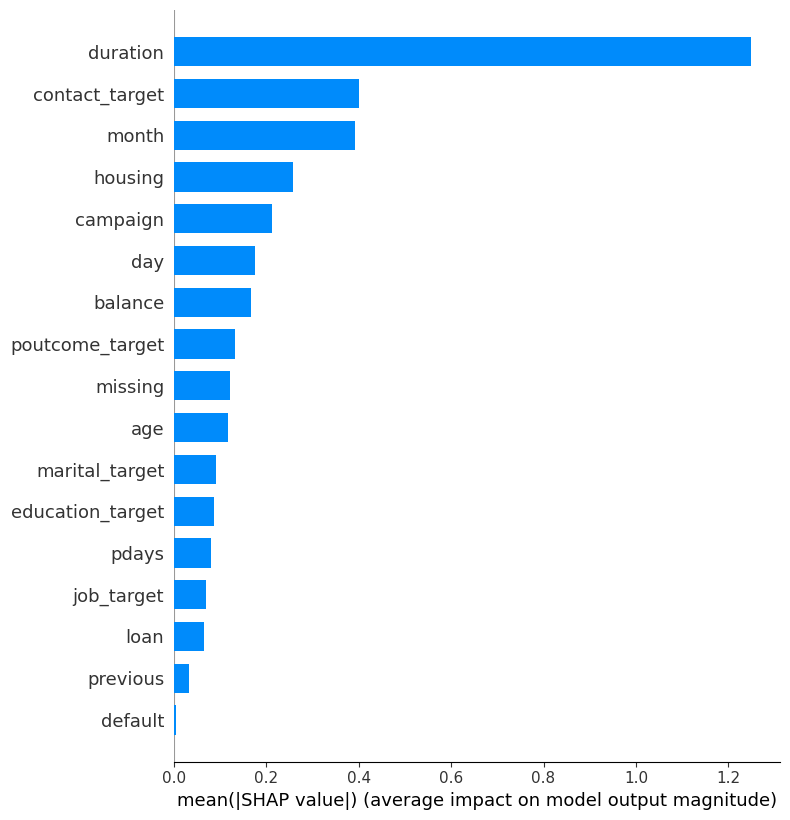

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(x)

shap.summary_plot(shap_values, x, plot_type="bar")

In [ ]:
# sample_submitの読み込み
submit = pd.read_csv('submit_sample.csv', header=None)

# 予測結果の適用
submit[1] = predict
submit.to_csv('submission.csv', header=None, index=False)

In [ ]:
! signate submit --competition-id=1 /content/submission.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.
